In [1]:
# using conda activate sindy

In [2]:
# sindy example

In [3]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close();
plt.rcParams.update({'font.size':16})

<Figure size 640x480 with 0 Axes>

In [4]:
import numpy as np
import pysindy as ps

t = np.linspace(0, 1, 100)
x = 3 * np.exp(-2 * t)
y = 0.5 * np.exp(t)
X = np.stack((x, y), axis=-1)  # First column is x, second is y

In [5]:
# ps.optimizers.STLSQ()

In [6]:
model = ps.SINDy(feature_names=["x", "y"])
model.fit(X, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x', 'y'],
      optimizer=STLSQ())

In [7]:
model.print()


(x)' = -2.000 x
(y)' = 1.000 y


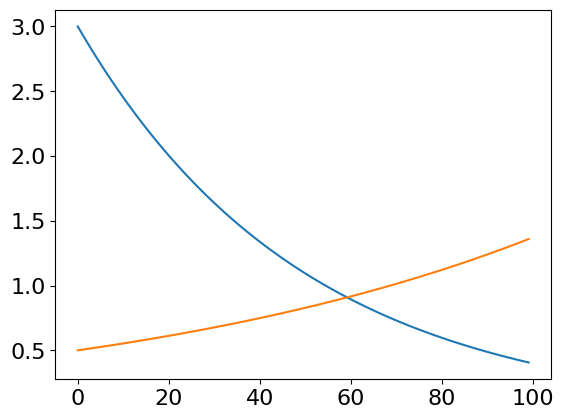

In [8]:
plt.plot(X)

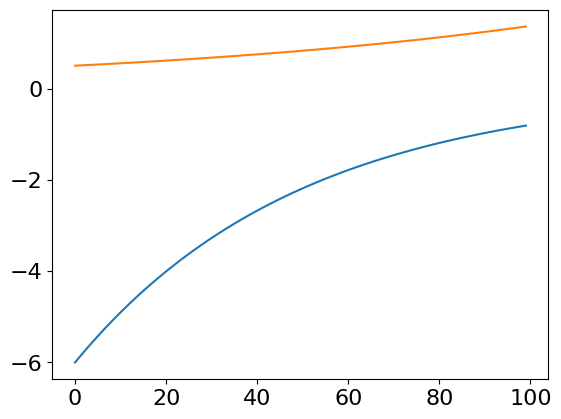

In [9]:
plt.plot(model.predict(X))

In [10]:
t0 = t[0]
x0 = 3 * np.exp(-2 * t0)
y0 = 0.5 * np.exp(t0)

In [11]:
sim = model.simulate([x0, t0], t=t)

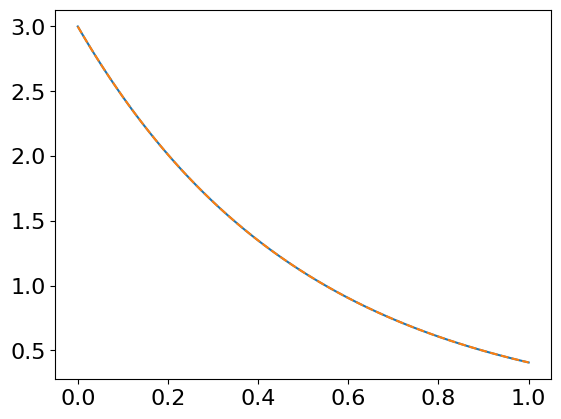

In [12]:
plt.plot(t, sim[:,0])
plt.plot(t, X[:,0], ls='--')

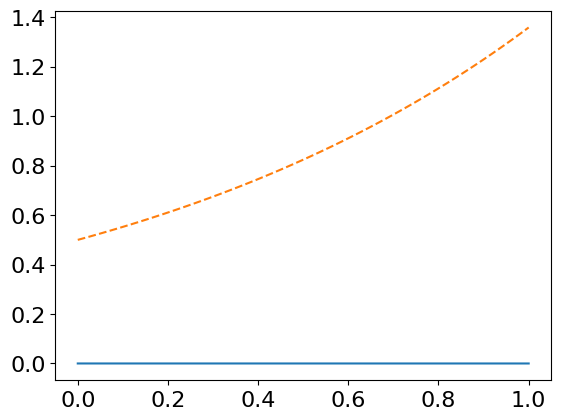

In [13]:
plt.plot(t, sim[:,1])
plt.plot(t, X[:,1], ls='--')

# waveforms

In [14]:
!ls /Users/sebastian.khan/personal/data/non_spinning_catalogue_dec_2022

metadata.csv strains.npy  times.npy


In [15]:

import numpy as np
import pandas as pd
import os

from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

In [16]:
datadir = "/Users/sebastian.khan/personal/data/non_spinning_catalogue_dec_2022"

In [17]:
metadata = pd.read_csv(os.path.join(datadir, 'metadata.csv'))
strains = np.load(os.path.join(datadir, 'strains.npy'))
times = np.load(os.path.join(datadir, 'times.npy'))

In [18]:
strains.shape

(55, 8620)

In [19]:
idx = 22
metadata.loc[[idx]]

name    q     fring     fdamp  duration  t_final
22  SXS_BBH_0180_Res4  1.0  0.088087  0.013596    9270.5    236.4

In [20]:
strain = strains[idx]

In [21]:
# mask = (times > -50) & (times < 50)
mask = (times > -100) & (times < 100)
times = times[mask]
strain = strain[mask]

In [22]:
def take_deriv(t, y, n=1):
    if y.dtype in ['complex128']:
        y_re = IUS(t, y.real).derivative(n)(t)
        y_im = IUS(t, y.imag).derivative(n)(t)
        return y_re - 1.j*y_im
    else:
        return IUS(t, y).derivative(n)(t)

In [23]:
d_strain = take_deriv(times, strain)
dd_strain = take_deriv(times, strain, 2)
ddd_strain = take_deriv(times, strain, 3)

In [24]:
def func(x, a, b, x0):
    return a * 1/np.cosh(b*(x - x0))

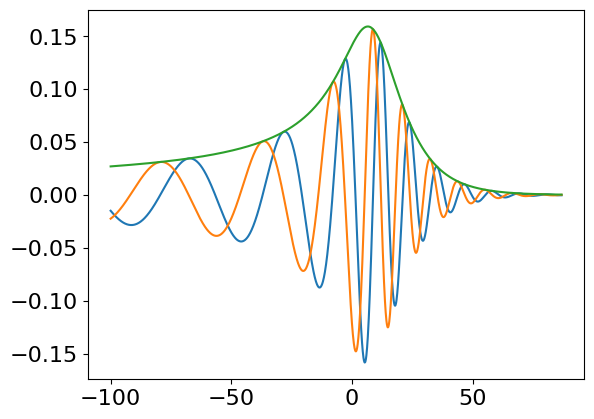

In [25]:
plt.plot(times, d_strain.real)
plt.plot(times, d_strain.imag)
plt.plot(times, np.abs(d_strain))

In [26]:
popt, pcov = curve_fit(func, times, np.abs(dd_strain))

In [27]:
popt

array([ 0.07064803, -0.08089884,  9.02576733])

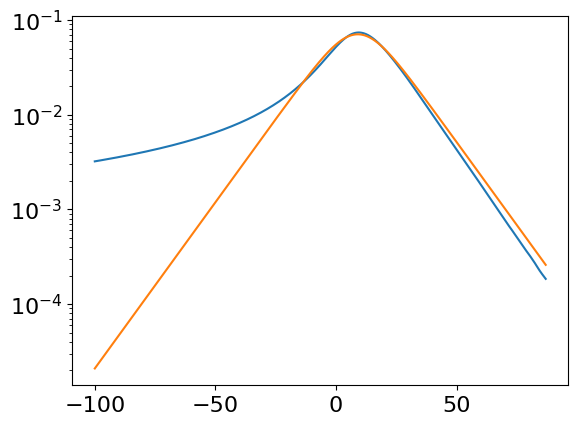

In [28]:
# plt.plot(times, dd_strain.real)
# plt.plot(times, dd_strain.imag)
plt.plot(times, np.abs(dd_strain))

plt.plot(times, func(times, *popt))

plt.yscale('log')

In [29]:
popt, pcov = curve_fit(func, times, np.abs(ddd_strain))

In [30]:
popt

array([ 0.03611128, -0.09625002, 12.0349506 ])

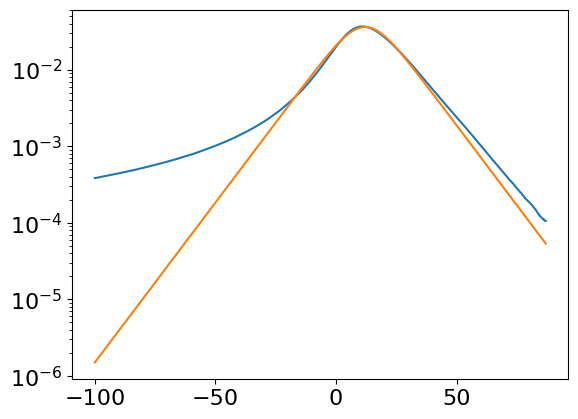

In [31]:
# plt.plot(times, ddd_strain.real)
# plt.plot(times, ddd_strain.imag)
plt.plot(times, np.abs(ddd_strain))

plt.plot(times, func(times, *popt))

plt.yscale('log')

In [32]:
amp = np.abs(strain)
phase = np.unwrap(np.angle(strain))
freq = take_deriv(times, phase)
d_freq = take_deriv(times, phase, 2)
dd_freq = take_deriv(times, phase, 3)

d_amp = take_deriv(times, amp)
dd_amp = take_deriv(times, amp, 2)
ddd_amp = take_deriv(times, amp, 3)

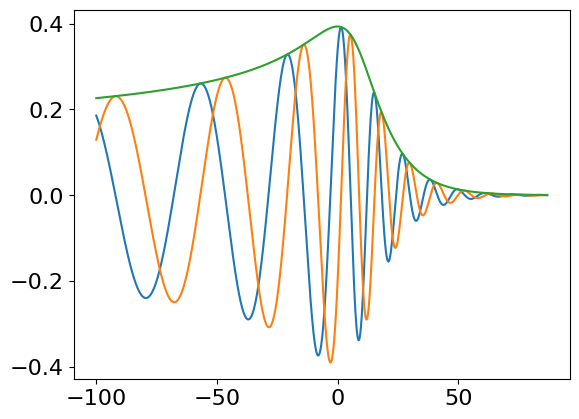

In [33]:
plt.plot(times, strain.real)
plt.plot(times, strain.imag)
plt.plot(times, amp)

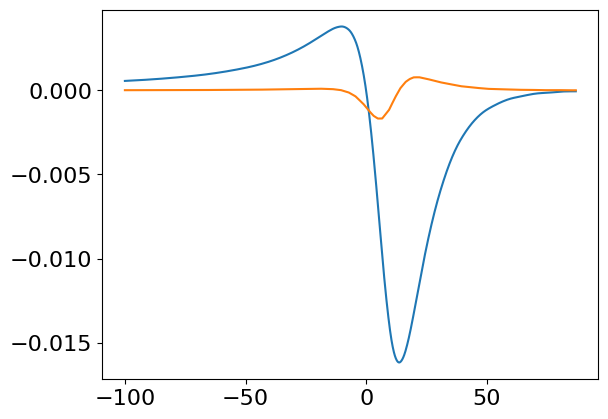

In [34]:
plt.plot(times, d_amp)
plt.plot(times, dd_amp)

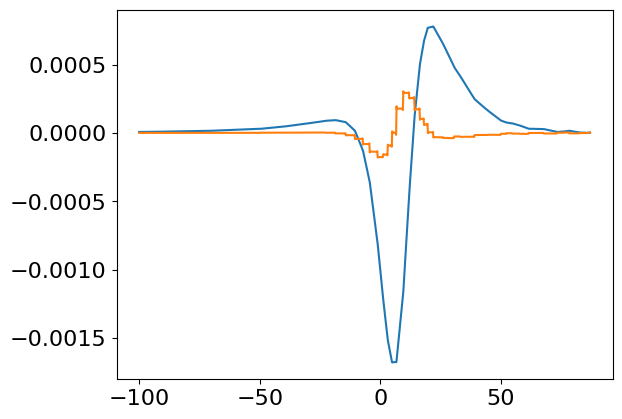

In [35]:
plt.plot(times, dd_amp)
plt.plot(times, ddd_amp)

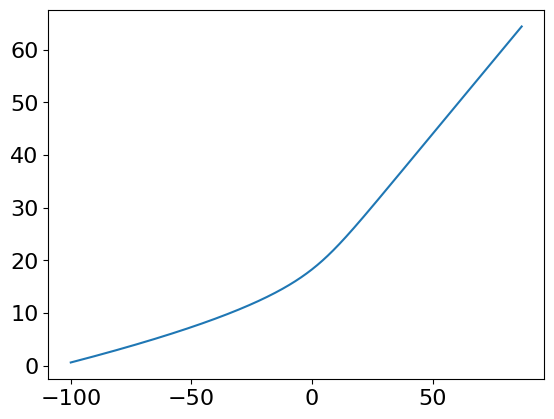

In [36]:
plt.plot(times, phase)

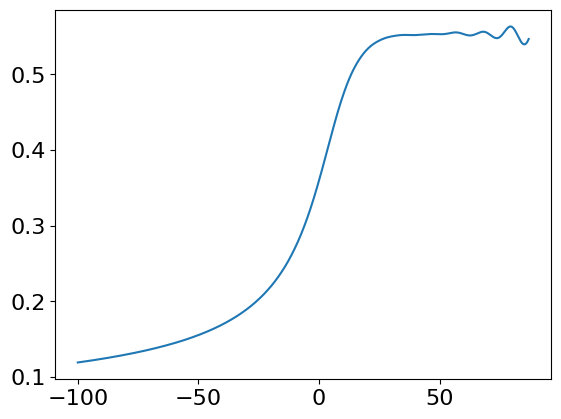

In [37]:
plt.plot(times, freq)

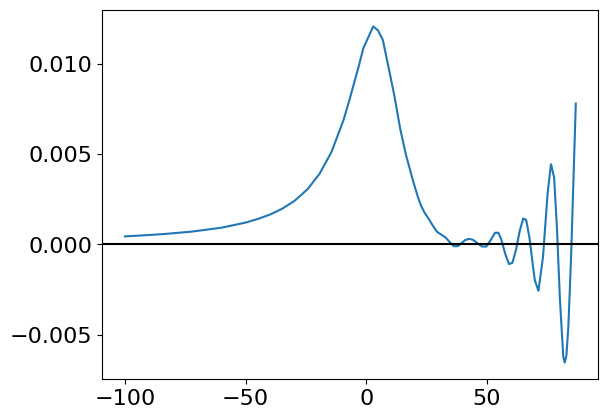

In [38]:
plt.plot(times, d_freq)
plt.axhline(0, c='k')

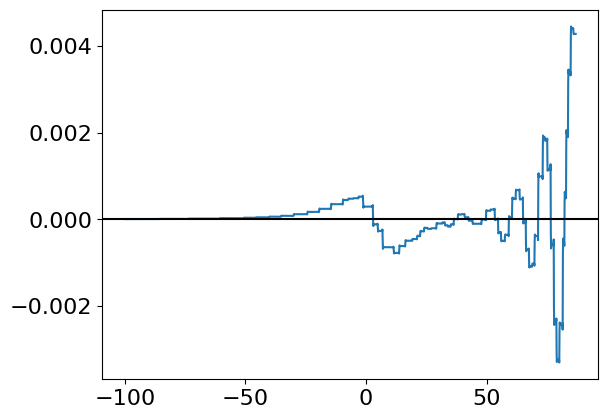

In [39]:
plt.plot(times, dd_freq)
plt.axhline(0, c='k')

In [40]:
def cauchy_hazard_function(x, a, b, x0):
    """
    https://www.2dcurves.com/trig/trigch.html
    """
    t1 = 1 + ((x-x0)/b)**2
    t2 = 1 - (2 * np.arctan((x-x0)/b)/np.pi)
    
    return a * 1 / (t1 * t2)
    
    
def weibull_function(x, a, b, x0):
    """https://www.mathworks.com/help/curvefit/list-of-library-models-for-curve-and-surface-fitting.html"""
    return a*b*(x-x0)**(b-1)*np.exp(-a*(x-x0)**b)

In [41]:
x = times
y = np.flip(d_freq)

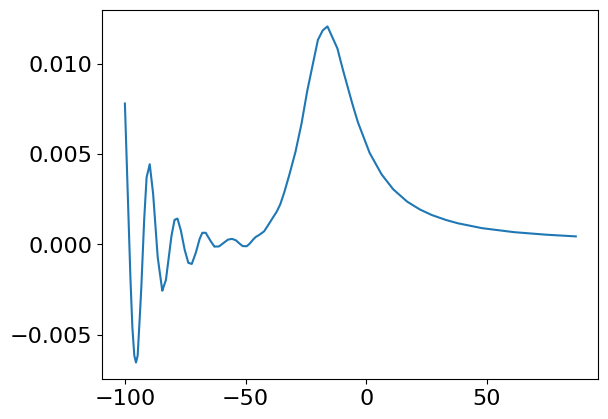

In [42]:
plt.plot(x, y)

In [43]:
func = cauchy_hazard_function
# func = weibull_function
popt, pcov = curve_fit(func, x, y)

In [44]:
popt

array([ 1.07609220e-02,  7.48471197e+00, -2.21974686e+01])

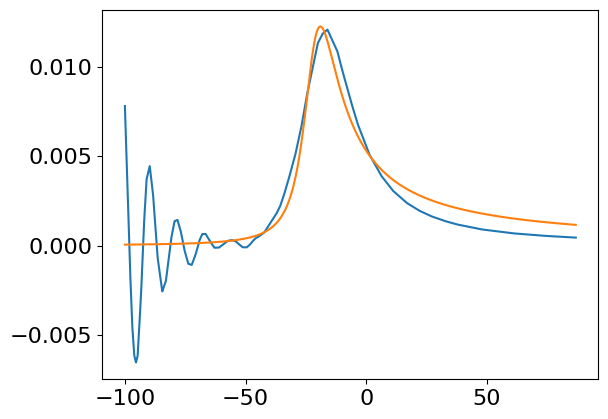

In [45]:
plt.plot(x, y)
plt.plot(times, func(times, *popt))

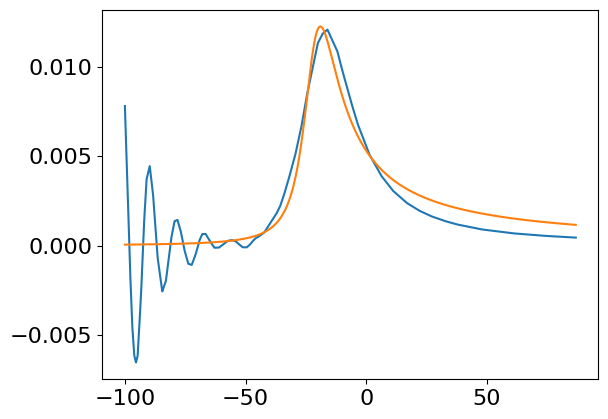

In [46]:
plt.plot(x, y)
plt.plot(times, func(times, *popt))

# sindy waveforms

In [47]:
t = x
# X = freq.reshape(-1, 1)
X = np.c_[freq, d_freq]

In [48]:
X.shape

(1870, 2)

In [49]:
t.shape

(1870,)

In [50]:
t

array([-100. ,  -99.9,  -99.8, ...,   86.7,   86.8,   86.9])

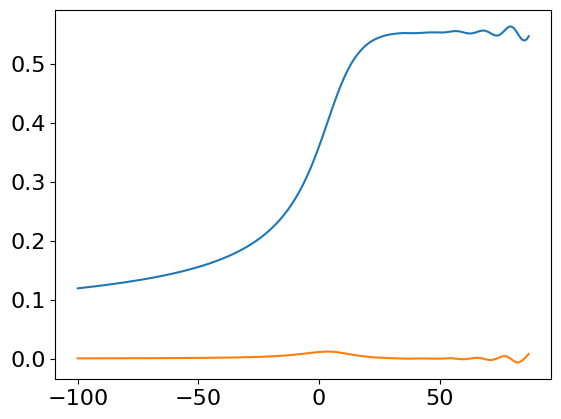

In [51]:
plt.plot(t, X)

In [52]:
differentiation_method = ps.FiniteDifference(order=2)

# Populate the library with trigonometric functions
feature_library = ps.FourierLibrary()

optimizer = ps.STLSQ(threshold=0.2)


model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"],
)
model.fit(X, t=t)
model.print()



(x)' = 1.000 sin(1 y)
(y)' = 0.000


/opt/homebrew/Caskroom/miniforge/base/envs/sindy/lib/python3.9/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(


In [53]:
model.print()


(x)' = 1.000 sin(1 y)
(y)' = 0.000


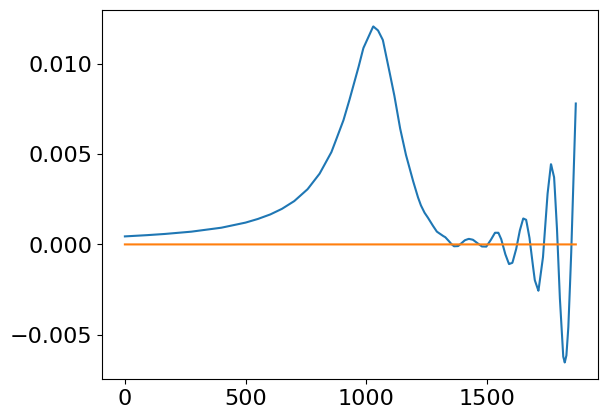

In [54]:
plt.plot(model.predict(X))

In [55]:
x

array([-100. ,  -99.9,  -99.8, ...,   86.7,   86.8,   86.9])

In [56]:
t = times

In [57]:
# X = strain.real[:,np.newaxis]
X = amp[:,np.newaxis]

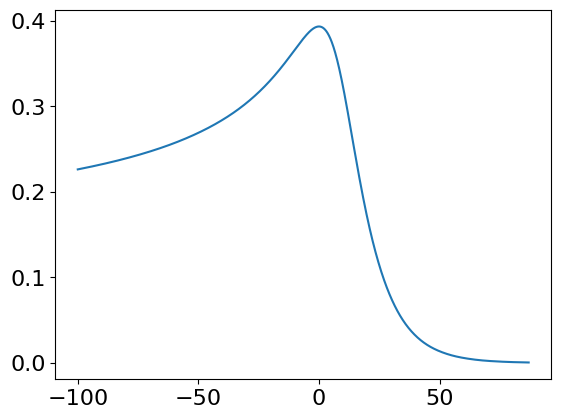

In [58]:
plt.plot(t, X)

In [59]:
differentiation_method = ps.FiniteDifference(order=3)

# Populate the library with trigonometric functions
feature_library = ps.FourierLibrary(n_frequencies=3)
# feature_library = ps.PolynomialLibrary(degree=2)

optimizer = ps.STLSQ(threshold=0.0001)


model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"],
)
model.fit(X, t=t)
model.print()



(x)' = 499.017 sin(1 x) + -98.996 cos(1 x) + -379.848 sin(1 y) + 156.945 cos(1 y) + 86.904 sin(2 x) + -57.949 cos(2 x)


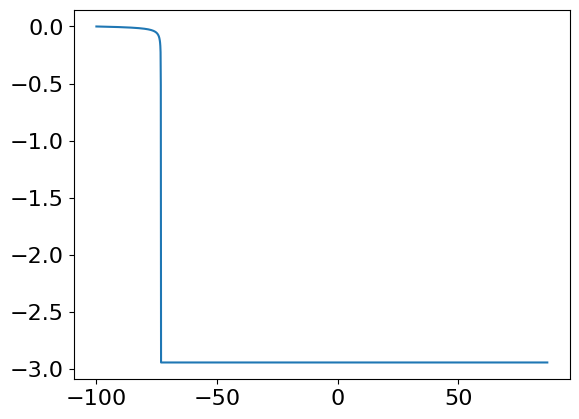

In [60]:
# plt.plot(model.predict(X))
plt.plot(t, model.simulate([0], t))